# Preprocess Dataset

## Setup

In [1]:
from pathlib import Path
import re
import os
import random
import math
from collections import Counter


import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from urlextract import URLExtract
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
from sklearn.preprocessing import StandardScaler

from utils import EmailDataset, tokenize, preprocess_row, compute_numeric_features, full_preprocess_text


# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


# Config 
DATA_CSV = "Phishing_Email.csv" # CSV
DATA_PREPROCESSED_DIR = Path("data/preprocessed") # Directory to save processed data
MAX_VOCAB = 40000
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

/home/enrico/Desktop/PED/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


[nltk_data] Downloading package punkt_tab to /home/enrico/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Download Dataset

In [2]:
from pathlib import Path

# Directory to save the downloaded dataset
RAW_DATA_DIR = Path("data/raw")

# Make sure the directory exists
RAW_DATA_DIR.mkdir(parents=True, exist_ok=True)

DATASET_NAME = "subhajournal/phishingemails"  # naserabdullahalam/phishing-email-dataset

# Check if datsets are already downloaded
if not any(RAW_DATA_DIR.iterdir()):
    print("Downloading dataset from Kaggle...")
    # Download the dataset from Kaggle
    os.system(f"kaggle datasets download -d {DATASET_NAME} -p {RAW_DATA_DIR} --unzip")
else:
    print("Dataset already exists. Skipping download.")

Dataset already exists. Skipping download.


## Setup

Looking for dataset at: data/raw/Phishing_Email.csv
   Unnamed: 0                                         Email Text  \
0           0  re : 6 . 1100 , disc : uniformitarianism , re ...   
1           1  the other side of * galicismos * * galicismo *...   
2           2  re : equistar deal tickets are you still avail...   
3           3  \nHello I am your hot lil horny toy.\n    I am...   
4           4  software at incredibly low prices ( 86 % lower...   

       Email Type  
0      Safe Email  
1      Safe Email  
2      Safe Email  
3  Phishing Email  
4  Phishing Email  

Dataset size: 18650
label
0    11322
1     7328
Name: count, dtype: int64


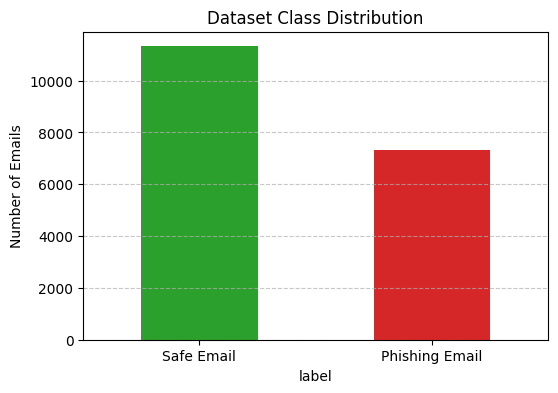

In [3]:
file_path = os.path.join(RAW_DATA_DIR, DATA_CSV)
print(f"Looking for dataset at: {file_path}")

assert os.path.exists(file_path), f"Dataset not found: {DATA_CSV}"
df = pd.read_csv(file_path)
df.columns = [c.strip() for c in df.columns]
print(df.head())


# Rename columns for consistency
df.rename(columns={"Email Text": "text", "Email Type": "type"}, inplace=True)


# Normalize labels: Phishing Email -> 1, Safe Email -> 0
df['label'] = df['type'].apply(lambda x: 1 if 'Phishing Email' in x else 0)

# Show dataset size and label distribution
print("\nDataset size:", len(df))
print(df['label'].value_counts())


# %%
# Cell 4 — Visualize Class Distribution
plt.figure(figsize=(6,4))
df['label'].value_counts().plot(kind='bar', color=['#2ca02c', '#d62728'])
plt.xticks(ticks=[0,1], labels=['Safe Email', 'Phishing Email'], rotation=0)
plt.title('Dataset Class Distribution')
plt.ylabel('Number of Emails')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

## Preprocess Dataset

In [4]:
file_path = os.path.join(RAW_DATA_DIR, DATA_CSV)
print(f"Looking for dataset at: {file_path}")

assert os.path.exists(file_path), f"Dataset not found: {DATA_CSV}"

import sys
from utils import full_preprocess_text

print("Starting preprocessing...")

tqdm.pandas(desc="Precomputing features")
df[["n_upper","n_exclaim","n_special","length","has_login_words"]] = df.progress_apply(compute_numeric_features, axis=1)
tqdm.pandas(desc="Preprocessing text")
df[["text", "n_urls", "urls"]] = df["text"].progress_apply(preprocess_row)
tqdm.pandas(desc="Tokenizing text")
df["tokens"] = df["text"].progress_apply(tokenize)

print("Preprocessing completed.")

Looking for dataset at: data/raw/Phishing_Email.csv
Starting preprocessing...


Preprocessing text:  50%|█████     | 9407/18650 [00:41<00:44, 205.54it/s]/home/enrico/Desktop/PED/utils.py:32: MarkupResemblesLocatorWarning: The input passed in on this line looks more like a URL than HTML or XML.

If you meant to use Beautiful Soup to parse the web page found at a certain URL, then something has gone wrong. You should use an Python package like 'requests' to fetch the content behind the URL. Once you have the content as a string, you can feed that string into Beautiful Soup.

However, if you want to parse some data that happens to look like a URL, then nothing has gone wrong: you are using Beautiful Soup correctly, and this warning is spurious and can be filtered. To make this warning go away, run this code before calling the BeautifulSoup constructor:

    from bs4 import MarkupResemblesLocatorWarning
    import warnings

    warnings.filterwarnings("ignore", category=MarkupResemblesLocatorWarning)
    
  return BeautifulSoup(text, "html.parser").get_text(separator=

Preprocessing completed.


In [5]:
print("Some examples after preprocessing:")
df.head(5)

Some examples after preprocessing:


,Unnamed: 0,text,type,label,n_upper,n_exclaim,n_special,length,has_login_words,n_urls,urls,tokens
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email,0,0,2,61,230,0,0,[],"[re, :, 6, ., 1100, ,, disc, :, uniformitarian..."
1,1,the other side of * galicismos * * galicismo *...,Safe Email,0,0,0,18,91,0,0,[],"[the, other, side, of, *, galicismos, *, *, ga..."
2,2,re : equistar deal tickets are you still avail...,Safe Email,0,0,0,96,305,0,0,[],"[re, :, equistar, deal, tickets, are, you, sti..."
3,3,hello i am your hot lil horny toy. i am the on...,Phishing Email,1,39,1,112,96,0,2,"[mail.com, http://www.mail.com/?sr=signup]","[hello, i, am, your, hot, lil, horny, toy, ., ..."
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email,1,0,0,27,91,0,0,[],"[software, at, incredibly, low, prices, (, 86,..."


## Save Dataframe

In [7]:
# Save Dataframe to a CSV file
processed_file_path_csv = os.path.join(DATA_PREPROCESSED_DIR, "preprocessed_data.csv")


# Drop columns that are not needed
df = df.drop(columns=["type", "Unnamed: 0"], errors="ignore")


# Create directory if it doesn't exist
# os.makedirs(os.path.dirname(processed_file_path), exist_ok=True)

# df.to_csv(processed_file_path, index=False)

# Save to npz

# Prepare arrays/lists to save
texts = df["text"].tolist()
tokens = df["tokens"].tolist()
labels = df["label"].to_numpy().astype(np.int32)
urls = df["urls"].tolist()
num_feats = df[
    ["n_urls", "n_upper", "n_exclaim", "n_special", "length", "has_login_words"]
].to_numpy(dtype=np.float32)

processed_file_path_npz = os.path.join(DATA_PREPROCESSED_DIR, "preprocessed_data.npz")
os.makedirs(os.path.dirname(processed_file_path_npz), exist_ok=True)
np.savez_compressed(
    processed_file_path_npz,
    texts=np.array(texts, dtype=object),
    tokens=np.array(tokens, dtype=object),
    labels=labels,
    urls=np.array(urls, dtype=object),
    num_feats=num_feats,
)

print(f"Preprocessed data saved to: {processed_file_path_npz}")

Preprocessed data saved to: data/preprocessed/preprocessed_data.npz
